In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict
from itertools import count
from tqdm import tqdm

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None): 
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    #env.printBoard()
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [4]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            #env.printBoard()
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            #env.printBoard()
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

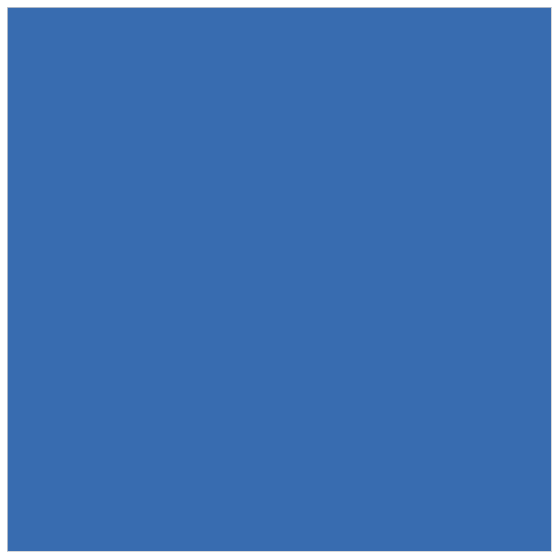

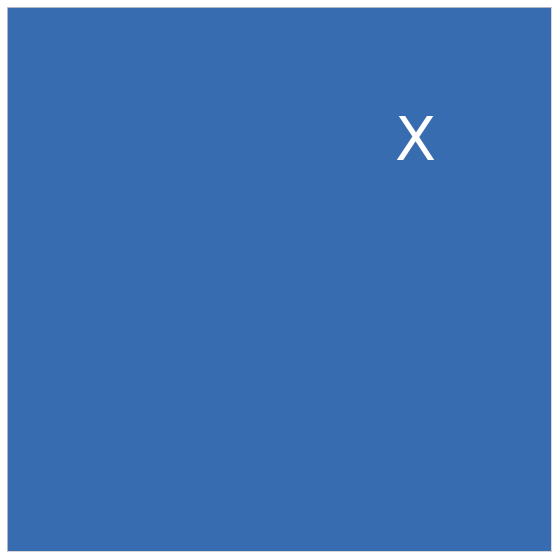

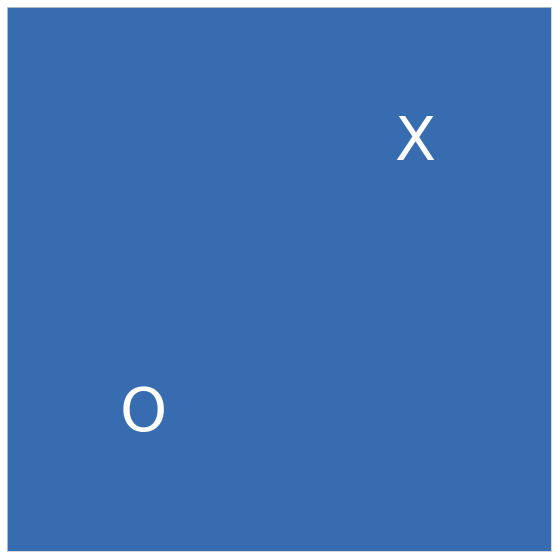

Крестики выиграли!


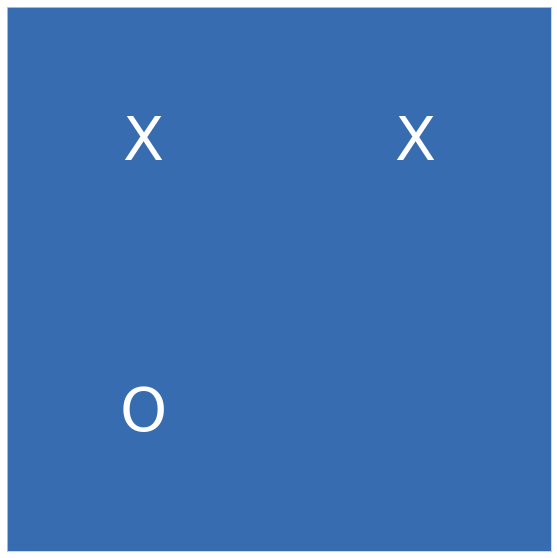

In [6]:
env = TicTacToe(n_rows=2, n_cols=2, n_win=2)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

# Часть 1
## Крестики-нолики при помощи Q-обучения

In [196]:
class Policy:
    def __init__(self, actions, alpha=0.1, epsilon=0.25, gamma=1):
        self.actions = actions
        self.Q = dict()
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
    
    def strategy(self, board_hash, empty_spaces):
        if board_hash not in self.Q.keys():
            self.Q[board_hash] = np.zeros(len(self.actions))
        self.Q[board_hash][[idx for idx in range(len(self.actions)) if idx not in empty_spaces]] = -10
        if np.random.random() > self.epsilon:
            self.Q[board_hash][[idx for idx in range(len(self.actions)) if idx not in empty_spaces]] = -10
            idx = np.argmax(self.Q[board_hash])
        else:
            idx = np.random.randint(len(empty_spaces))
            idx = empty_spaces[idx]
        return idx

    def update_Q(self, board_hash, new_board_hash, action, reward, empty_spaces):
        if new_board_hash not in self.Q.keys():
            self.Q[new_board_hash] = np.zeros(len(self.actions))
            self.Q[new_board_hash][[idx for idx in range(len(self.actions)) if idx not in empty_spaces]] = -10
        if board_hash in self.Q.keys():
            self.Q[board_hash][action] = self.Q[board_hash][action] + \
                        self.alpha * (reward + self.gamma * np.max(self.Q[new_board_hash]) - \
                        self.Q[board_hash][action])


def run_episode(env, pi1, pi2, random_crosses=False, random_naughts=False, print_board=False):
    env.reset()
    board_hash, empty_spaces, cur_turn = env.getState()
    rewards = []
    while True:
        if empty_spaces is None:
            empty_spaces = env.getEmptySpaces()
        if cur_turn == 1 and random_crosses:
            idx = np.random.randint(len(empty_spaces))
            action = empty_spaces[idx]
        if cur_turn == -1 and random_naughts:
            idx = np.random.randint(len(empty_spaces))
            action = empty_spaces[idx]
        if cur_turn == 1 and not random_crosses:
            idx = pi1.strategy(board_hash, [env.int_from_action(x) for x in empty_spaces])
            action = env.action_from_int(idx)
        if cur_turn == -1 and not random_naughts:
            idx = pi2.strategy(board_hash, [env.int_from_action(x) for x in empty_spaces])
            action = env.action_from_int(idx)
        

        (board_hash, empty_spaces, cur_turn), reward, done, info = env.step(action)
        rewards.append(reward)
        
        if print_board:
            plot_board(env, pi1)
        if done:
            break
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)


def conduct_experiments_pi(env, pi1, pi2, random_crosses=False, random_naughts=False, num_experiments=5000):
    total_reward1 = []
    total_reward2 = []
    for i in range(num_experiments):

        reward1, reward2 = run_episode(env, pi1, pi2, random_crosses=random_crosses, random_naughts=random_naughts, print_board=False)
        total_reward1.append(reward1)
        total_reward2.append(reward2)
    return np.mean(total_reward1), np.mean(total_reward2)


def Q_learning_episode(env, pi1, pi2, random_crosses=False, random_naughts=False):
    env.reset()
    board_hash, empty_spaces, cur_turn = env.getState()
    prev_hash = [board_hash, None]
    new_hash = [None, None]
    while True:
        if empty_spaces is None:
            empty_spaces = env.getEmptySpaces()
        if cur_turn == 1 and random_crosses:
            idx = np.random.randint(len(empty_spaces))
            action = empty_spaces[idx]
        if cur_turn == -1 and random_naughts:
            idx = np.random.randint(len(empty_spaces))
            action = empty_spaces[idx]
        if cur_turn == 1 and not random_crosses:
            idx = pi1.strategy(board_hash, [env.int_from_action(x) for x in empty_spaces])
            action = env.action_from_int(idx)
        if cur_turn == -1 and not random_naughts:
            idx = pi2.strategy(board_hash, [env.int_from_action(x) for x in empty_spaces])
            action = env.action_from_int(idx)

        (board_hash, empty_spaces, cur_turn), reward, done, info = env.step(action)

        if cur_turn == -1 and pi1 is not None:
            pi1.update_Q(prev_hash[0], new_hash[0], env.int_from_action(action), reward, [env.int_from_action(x) for x in empty_spaces])
        if cur_turn == 1 and pi2 is not None:
            reward = -reward
            pi2.update_Q(prev_hash[1], new_hash[1], env.int_from_action(action), reward, [env.int_from_action(x) for x in empty_spaces])
            
        if cur_turn == -1:
            prev_hash = [prev_hash[0], board_hash]
            new_hash = [new_hash[0], board_hash]
        else:
            prev_hash = [board_hash, prev_hash[1]]
            new_hash = [board_hash, new_hash[1]]
          
        if done:
            break


skip_episodes = 2000

def Q_learning(env, pi1, pi2, r_for=1, random_crosses=False, random_naughts=False, print_board=False, num_episodes=100000, num_experiments=2000, to_plot=True):
    q_rewards = []
    k = 0 if r_for == 1 else 1
    for i in tqdm(range(num_episodes)):
        Q_learning_episode(env, pi1, pi2, random_crosses, random_naughts)
        if to_plot and i % skip_episodes == 0:
            q_rewards.append(conduct_experiments_pi(env, pi1, pi2, random_crosses, random_naughts, num_experiments)[k])

    if to_plot:
        return q_rewards
    else:
        return conduct_experiments_pi(env, pi1, pi2, random_crosses, random_naughts, num_experiments)

In [197]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
A = tuple(range(N_ROWS * N_COLS))
pi1 = Policy(A)

In [198]:
num_episodes = 50000
rewards = Q_learning(env, pi1, None, random_crosses=False, random_naughts=True, num_episodes=num_episodes)

100%|██████████| 50000/50000 [01:24<00:00, 590.09it/s] 


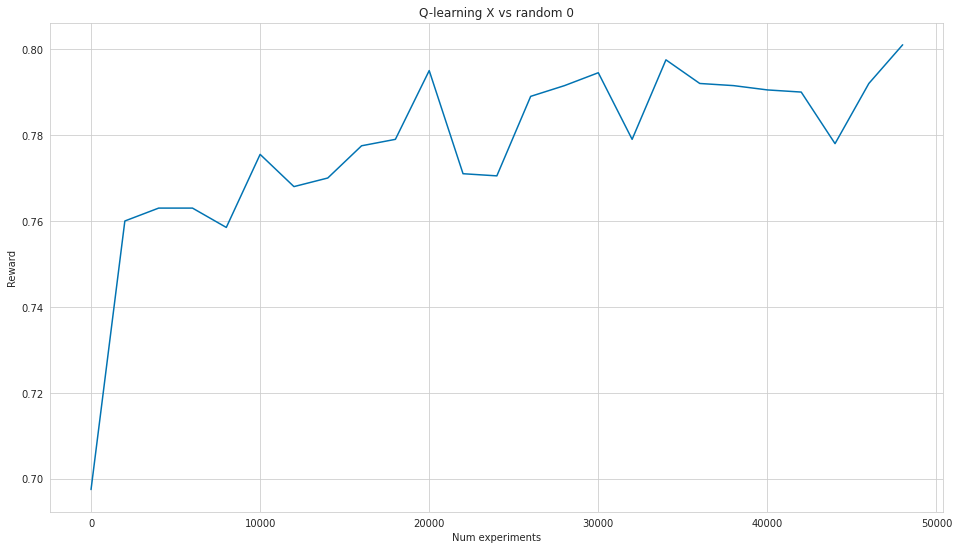

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('Q-learning X vs random 0')
plt.plot(range(0, num_episodes, skip_episodes), rewards)
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

In [181]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
A = tuple(range(N_ROWS * N_COLS))
pi2 = Policy(A)

In [182]:
num_episodes = 50000
rewards = Q_learning(env, None, pi2, r_for=-1, random_crosses=True, random_naughts=False, num_episodes=num_episodes)

100%|██████████| 50000/50000 [01:05<00:00, 758.34it/s] 


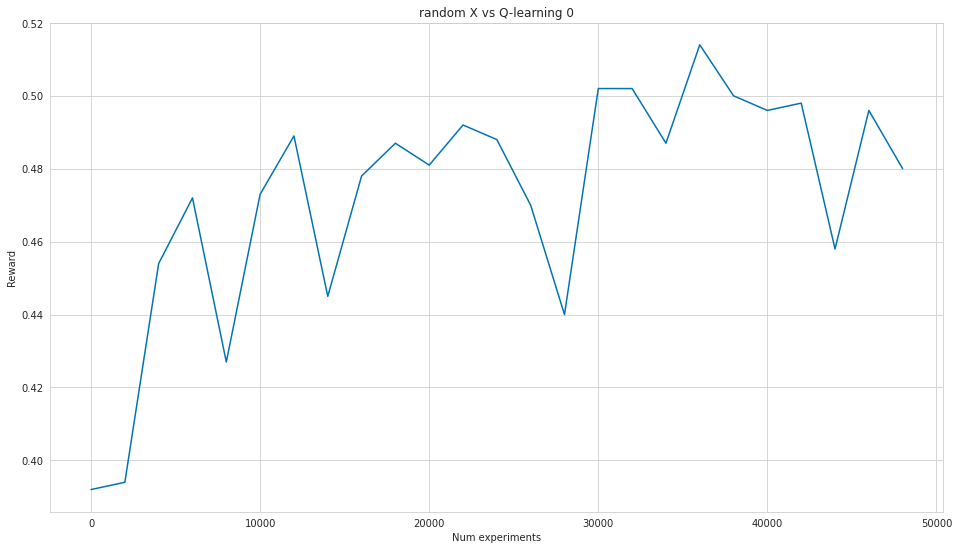

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('random X vs Q-learning 0')
plt.plot(range(0, num_episodes, skip_episodes), rewards)
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

Видим, что крестики обучаются гораздо лучше ноликов. Предел награды 0.8-0.9, не смогу установить, где у меня ошибка в реализации. Но явно видно, что политика обучается.

Попробуем то же самое для крестиков-ноликов 4х4

In [204]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
A = tuple(range(N_ROWS * N_COLS))
pi1 = Policy(A)

In [205]:
num_episodes = 200000
rewards = Q_learning(env, pi1, None, random_crosses=False, random_naughts=True, num_episodes=num_episodes)

100%|██████████| 200000/200000 [13:03<00:00, 255.11it/s]


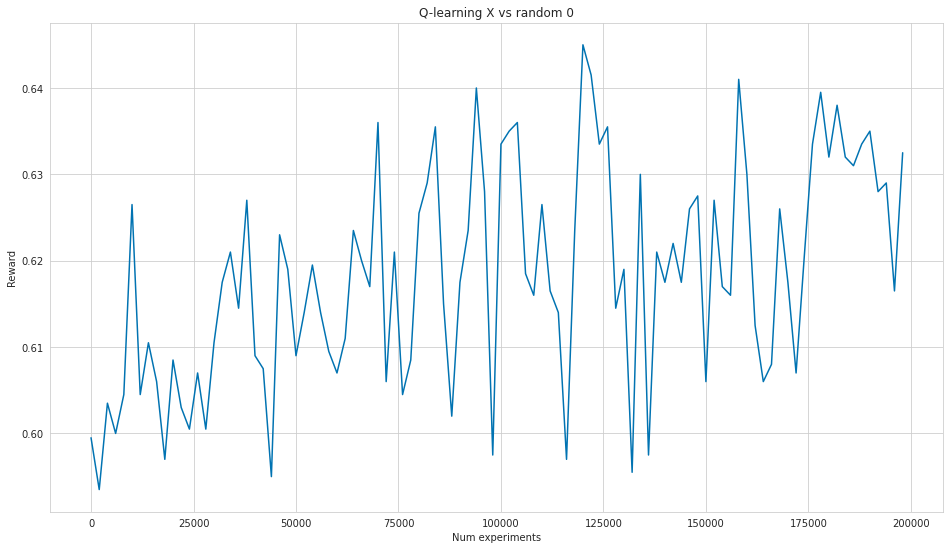

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('Q-learning X vs random 0')
plt.plot(range(0, num_episodes, skip_episodes), rewards)
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

Тут примерно та же ситуация, что и в 3х3, но итераций для обучения требуется сильно больше

# Часть 2

### Добавим нейронных сетей
Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.


In [6]:
from network_utils import *

In [17]:
class DQN(nn.Module):
    def __init__(self, n_rows=3, n_cols=3, hidden_size=512):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(n_cols, n_rows))
        self.lin1 = nn.Linear(hidden_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, n_rows * n_cols)       
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.squeeze(-1).squeeze(-1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [22]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
A = tuple(range(N_ROWS * N_COLS))

criterion = F.l1_loss

model_crosses = DQN(N_ROWS, N_COLS)
optimizer1 = optim.Adam(model_crosses.parameters(), lr=3e-4, weight_decay=1e-10)

model_naughts = DQN(N_ROWS, N_COLS)
optimizer2 = optim.Adam(model_naughts.parameters(), lr=3e-4, weight_decay=1e-10)

In [23]:
histories, losses, iters = run_learning(env, (model_crosses, optimizer1, None), (model_naughts, optimizer2, None), criterion,
    episodes=5000, eps_init=0.5, batch_size=512, gamma=0.9)

100%|██████████| 5000/5000 [09:08<00:00,  9.12it/s, l1=0.111, l2=0.0831, p1=0.85, p2=0.715, eps=0.5]


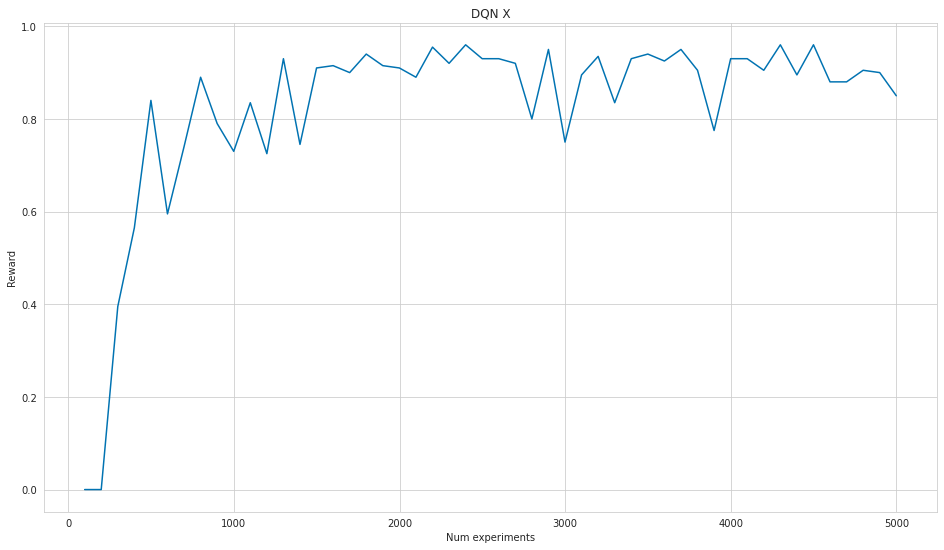

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('DQN X')
plt.plot(iters, histories[0])
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

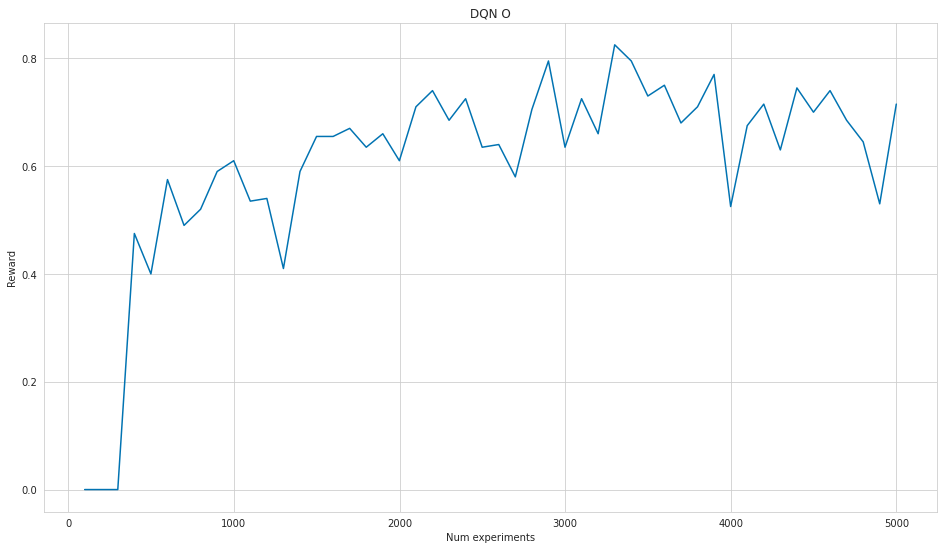

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('DQN O')
plt.plot(iters, histories[1])
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

DQN показала себя сильно лучше, чем Q-learning. Видно, что предела награды сетка достигает уже через 1000 эпох

Для 4х4:

In [26]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
A = tuple(range(N_ROWS * N_COLS))

criterion = F.l1_loss

model_crosses = DQN(N_ROWS, N_COLS)
optimizer1 = optim.Adam(model_crosses.parameters(), lr=3e-4, weight_decay=1e-10)

model_naughts = DQN(N_ROWS, N_COLS)
optimizer2 = optim.Adam(model_naughts.parameters(), lr=3e-4, weight_decay=1e-10)

In [27]:
histories, losses, iters = run_learning(env, (model_crosses, optimizer1, None), (model_naughts, optimizer2, None), criterion,
    episodes=15000, eps_init=0.5, batch_size=512, gamma=0.9)

100%|██████████| 15000/15000 [34:41<00:00,  7.21it/s, l1=0.196, l2=0.061, p1=0.765, p2=0.7, eps=0.5]


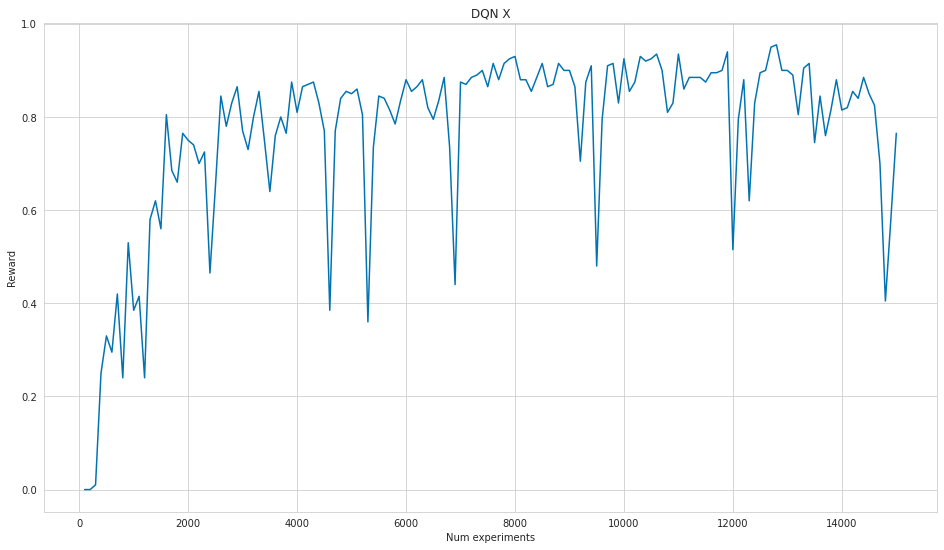

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('DQN X')
plt.plot(iters, histories[0])
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

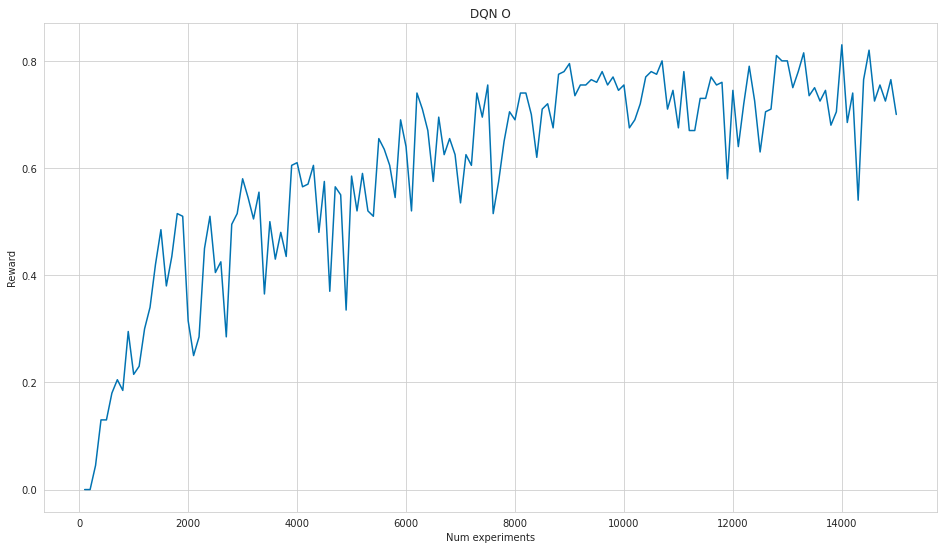

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('DQN O')
plt.plot(iters, histories[1])
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

Достигаем примерно тех же результатов, что и с 3х3, но только гораздо дольше, что кажется логичным.

### Реализуйте Double DQN и/или Dueling DQN.

In [30]:
class DuelingDQN(nn.Module):
    def __init__(self, n_rows=3, n_cols=3, hidden_size=512):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
    
        self.V = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

        self.A = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 9),
        )
        
    def forward(self, x):
        x = F.relu(self.conv(x)).squeeze(-1).squeeze(-1)
        a = self.A(x)
        v = self.V(x)
        return v + (a - a.mean(dim=1, keepdim=True).expand(x.size(0), 9))

In [33]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
A = tuple(range(N_ROWS * N_COLS))

criterion = F.l1_loss

model_crosses = DuelingDQN(N_ROWS, N_COLS)
optimizer1 = optim.Adam(model_crosses.parameters(), lr=3e-4, weight_decay=1e-10)

model_naughts = DuelingDQN(N_ROWS, N_COLS)
optimizer2 = optim.Adam(model_naughts.parameters(), lr=3e-4, weight_decay=1e-10)

In [34]:
histories, losses, iters = run_learning(env, (model_crosses, optimizer1, None), (model_naughts, optimizer2, None), criterion,
    episodes=5000, eps_init=0.5, batch_size=256, gamma=0.9)

100%|██████████| 5000/5000 [08:03<00:00, 10.34it/s, l1=0.0559, l2=0.0665, p1=0.885, p2=0.75, eps=0.5]


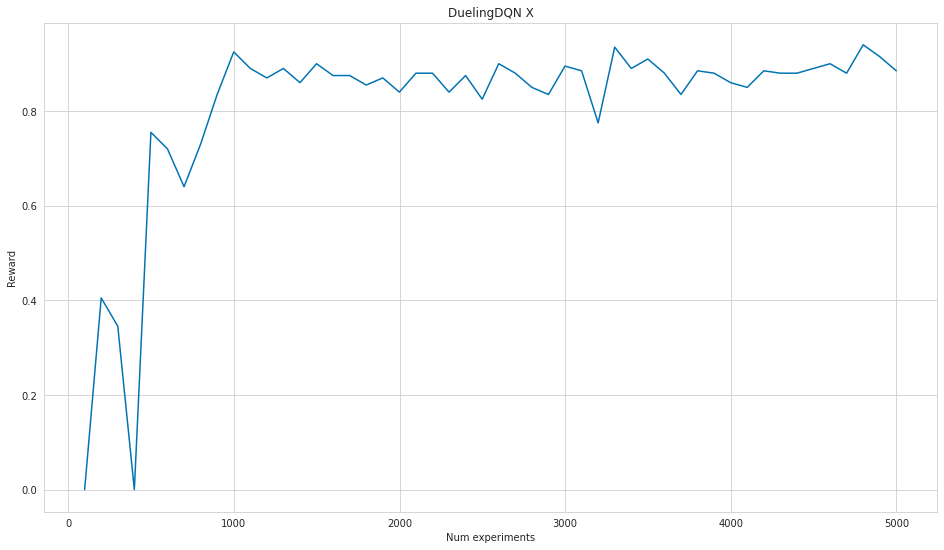

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('DuelingDQN X')
plt.plot(iters, histories[0])
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

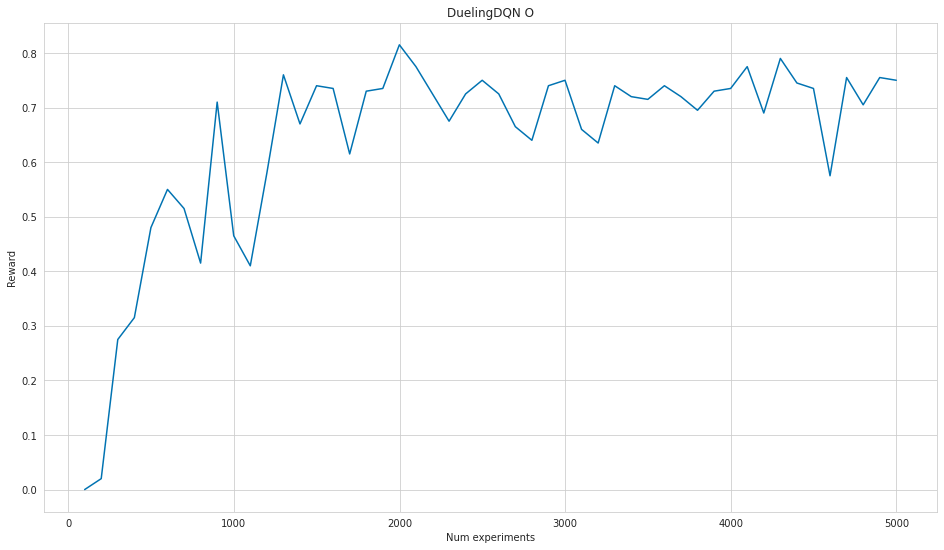

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('DuelingDQN O')
plt.plot(iters, histories[1])
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.show()

Сразу можно заметить, что обучение стало сильно стабильнее и столько же эпох обучилось немного быстрее

С 4х4 пробовать не стал. Ожидаю те же изменения, что и в прошлых пунктах

# Часть 3

К сожалению, не успел :(